<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Task 1: Project Overview and Import Libraries

In [2]:
!cp '/content/drive/My Drive/Generate Synthetic Images/DCGAN.png' .
!cp '/content/drive/My Drive/Generate Synthetic Images/plot_utils.py' .

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Task 2: Load and Preprocess the Data

In [5]:
classes = {
0 : 'T-shirt/top',
1 : 'Trouser',
2 : 'Pullover',
3 : 'Dress',
4 : 'Coat',
5 : 'Sandal',
6 : 'Shirt',
7 : 'Sneaker',
8 : 'Bag',
9 : 'Ankle boot'
}

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

4423680/4422102 [==============================] - 0s 0us/step


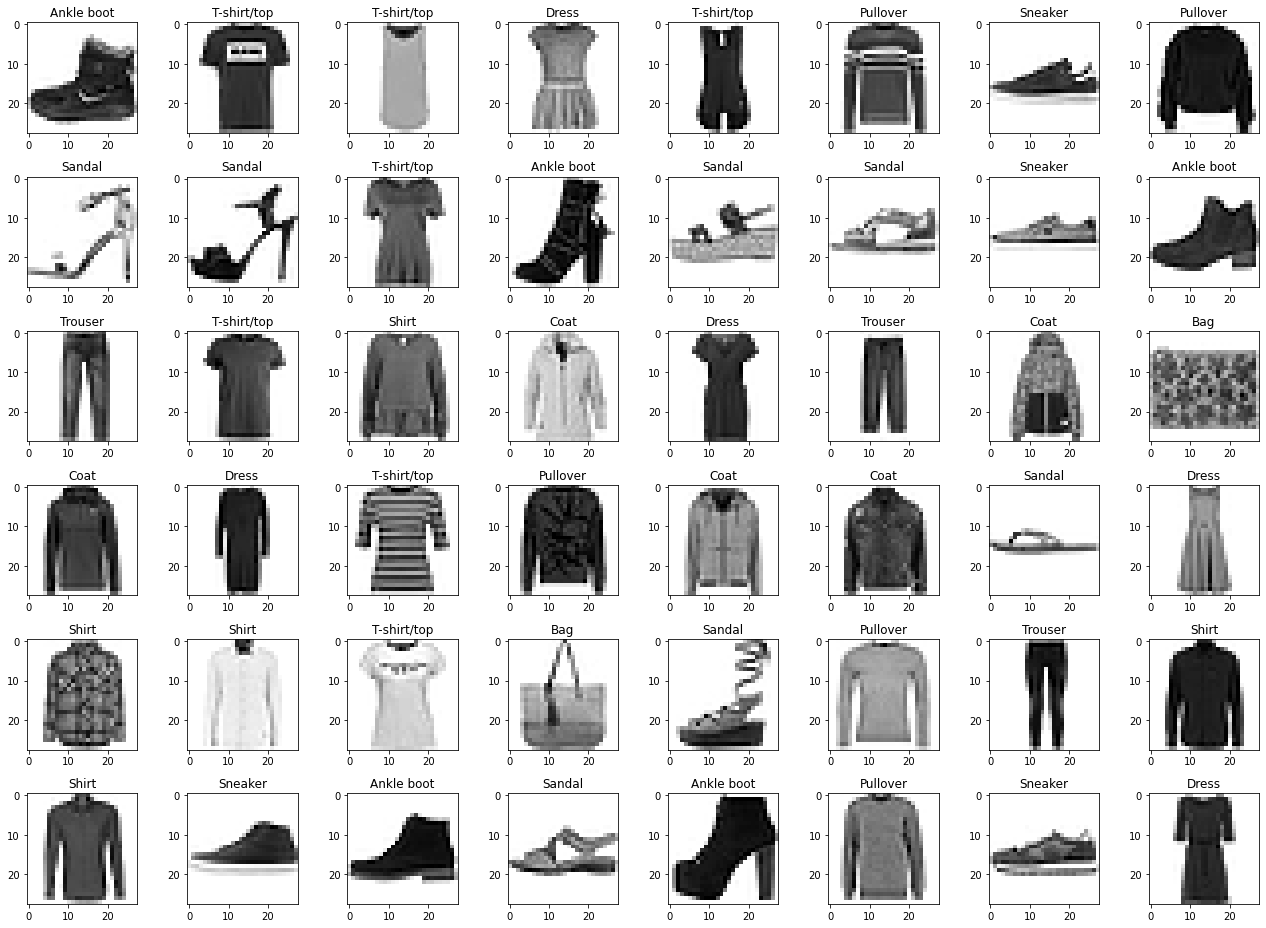

In [6]:
plt.figure(figsize=(18, 13))
for i in range(48):
  plt.subplot(6,8,i+1)
  plt.xlabel, plt.ylabel = [], []
  plt.grid(False)
  plt.title(classes[y_train[i]])
  plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

## Task 3: Create Batches of Training Data

In [46]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1024)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [54]:
num_features = 100

generator = keras.models.Sequential([
  keras.layers.Dense(7*7*512, input_shape=[num_features]),
  keras.layers.Reshape([7,7,512]),
  keras.layers.BatchNormalization(),
  # keras.layers.Conv2DTranspose(512, (5,5), (2,2), padding='same', activation='selu'),
  # keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(256, (5,5), (2,2), padding='same', activation='selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding='same', activation='selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, (5,5), padding='same', activation='selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(1, (5,5), padding='same', activation='tanh'),
])

# generator = keras.models.Sequential([
#   keras.layers.Dense(7*7*128, input_shape=[num_features]),  #7*7*256
#   keras.layers.Reshape([7,7,128]), #7,7,256
#   keras.layers.BatchNormalization(),
#   keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
#   keras.layers.BatchNormalization(),
#   keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh'),
# ])

generator.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
reshape_18 (Reshape)         (None, 7, 7, 512)         0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 14, 14, 256)       3277056   
_________________________________________________________________
batch_normalization_59 (Batc (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_transpose_59 (Conv2DT (None, 28, 28, 128)       819328    
_________________________________________________________________
batch_normalization_60 (Batc (None, 28, 28, 128)     

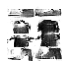

In [44]:
noise = tf.random.normal([1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image)

## Task 5: Build the Discriminator Network for DCGAN

In [57]:
discriminator = keras.models.Sequential([
  keras.layers.Conv2D(64, (5,5), (2,2), 'same', input_shape=[28, 28, 1]),
  keras.layers.LeakyReLU(.2),
  keras.layers.Dropout(.3),
  keras.layers.Conv2D(128, (5,5), (2,2), 'same'),
  keras.layers.LeakyReLU(.2),
  keras.layers.Dropout(.3),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(256, (5,5), (1,1), 'same'),
  keras.layers.LeakyReLU(.2),
  keras.layers.Dropout(.3),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

# discriminator = keras.models.Sequential([
#   keras.layers.Conv2D(64, (5,5), (2,2), 'same', input_shape=[28, 28, 1]),
#   keras.layers.LeakyReLU(.2),
#   keras.layers.Dropout(.3),
#   keras.layers.Conv2D(128, (5,5), (2,2), 'same'),
#   keras.layers.LeakyReLU(.2),
#   keras.layers.Dropout(.3),
#   keras.layers.Flatten(),
#   keras.layers.Dense(1, activation='sigmoid')
# ])

# decision = discriminator(generated_image)
# print(decision)
discriminator.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 7, 7, 128)       

## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [58]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Task 7: Define Training Procedure

In [59]:
seed = tf.random.normal(shape=[batch_size, 100])

In [70]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(1,epochs)):
    print('epoch %d/%d'%(epoch+1, epochs))
    for X_batch in dataset:
      noise = tf.random.normal([batch_size, num_features])
      generated_images = generator(noise)
      X_fake_real = tf.concat([generated_images, X_batch], axis=0)
      y01 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_real, y01)
      discriminator.trainable = False
      y11 = tf.constant([[1.]]*batch_size)
      gan.train_on_batch(noise, y11)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [61]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [62]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

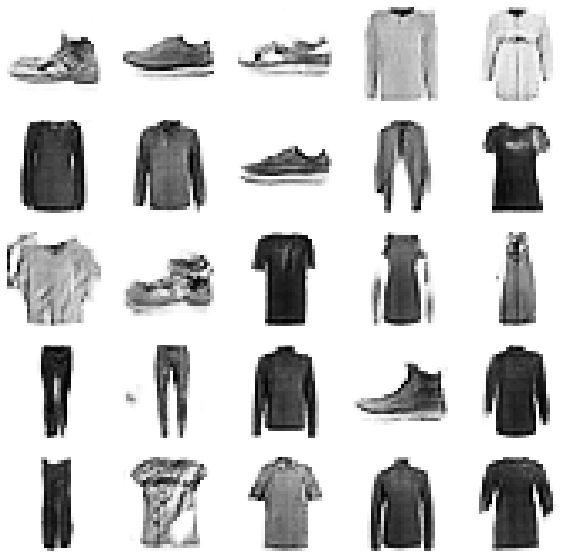

CPU times: user 7min 36s, sys: 50.7 s, total: 8min 26s
Wall time: 22min 46s


In [71]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Task 9: Generate Synthetic Images with DCGAN

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1062, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1268, in close
    self.display(pos=0)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1435, in display
    self.sp(self.__repr__() if msg is None else msg)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1065, in __repr__
    return self.format_meter(**self.format_dict)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 424, in format_meter
    l_bar = prefix if bool_prefix_colon_already else prefix + ": "
TypeError: unsupported operand type(s) for +: 'range' and 'str'


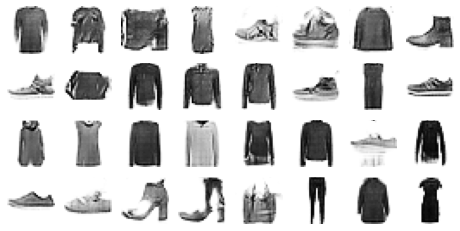

In [77]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

In [79]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# import IPython
# display.Image(filename=anim_file)

ValueError: ignored

In [84]:
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')
gan.save('gan.h5')

!cp gan_generator.h5 '/content/drive/My Drive/Generate Synthetic Images'
!cp gan_discriminator.h5 '/content/drive/My Drive/Generate Synthetic Images'
!cp gan.h5 '/content/drive/My Drive/Generate Synthetic Images'

!cp dcgan.gif '/content/drive/My Drive/Generate Synthetic Images'

filenames_ = glob.glob('image_*.png')
for f in filenames_:
  !cp '{f}' '/content/drive/My Drive/Generate Synthetic Images'